In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from scikitplot.metrics import plot_ks_statistic, plot_roc, plot_precision_recall

/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/jlc/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
%matplotlib inline
%load_ext watermark
%watermark -iv -psklearn,scikitplot

matplotlib 3.0.3
numpy      1.16.4
seaborn    0.9.0
pandas     0.24.2
sklearn 0.21.1
scikitplot 0.3.7


In [4]:
df = pd.read_pickle('../data/churn_cleaned.pkl')

# Make cohorts  
Churn is generally done as a cohort analysis -- customers who entered at the same time have experienced similar
ads, service outages, economic conditions, and other exogenous events not necessarily recorded in a customer database. It tends to do a better job comparing apples to apples.

I know from EDA that the churn is not divided evenly by customer tenure, but I also don't want to make my
sample sizes too small. 

If I were a real cable company, there'd be plenty of data. But, I've only got 7000 rows from Kaggle. So, I'm
only going to make four cohorts. By dividing them by quartiles, I get even-sized cohorts at the expense of having
uniform bands of time per cohort.

My cohorts are 0 to 9 months, then 10 to 29, 30 to 55, and 56 to 72 months.

In [5]:
n_cohorts = 4 
tenure_c, bins = pd.qcut(df.tenure, n_cohorts, labels=range(n_cohorts), retbins=True)

In [6]:
tenure_c.value_counts()

0    1854
3    1755
2    1719
1    1715
Name: tenure, dtype: int64

In [7]:
df['tenure_c'] = tenure_c

cohort_table = pd.DataFrame(index=range(n_cohorts), columns=['min_tenure','max_tenure', 'name'])
g = df.groupby('tenure_c')
for i in range(n_cohorts):
    group = g.get_group(i)
    cohort_table.loc[i,'min_tenure'] = group['tenure'].min()
    cohort_table.loc[i,'max_tenure'] = group['tenure'].max()
cohort_table.name = cohort_table.min_tenure.astype(str) + " - " + cohort_table.max_tenure.astype(str) + " months"

In [8]:
cohorts = [ df.query(f"tenure_c == {i}") for i in range(n_cohorts) ]

In [9]:
for i,cohort in enumerate(cohorts):
    counts = cohort.Churn.value_counts()
    
    cohort_table.loc[i,'observations'] = cohort.shape[0]
    cohort_table.loc[i, 'churn_yes'] = counts['Yes']
    cohort_table.loc[i, 'churn_no'] = counts['No']

cohort_table['churn_pct'] = cohort_table['churn_yes'] / cohort_table['observations']
cohort_table

,min_tenure,max_tenure,name,observations,churn_yes,churn_no,churn_pct
0,0,9,0 - 9 months,1854.0,923.0,931.0,0.497843
1,10,29,10 - 29 months,1715.0,486.0,1229.0,0.283382
2,30,55,30 - 55 months,1719.0,324.0,1395.0,0.188482
3,56,72,56 - 72 months,1755.0,136.0,1619.0,0.077493


# Preprocessing

To preprocess, I'm one-hot encoding the categorical variables and using StandardScaler for the 
numerical features. 

For logistic regression, I don't want collinear features. I'm dropping "No internet service" everywhere
for that reason. i.e. "OnlineBackup_No internet service" and "DeviceProtection_No internet service" should
be exactly the same one-hot vector.

In [10]:
def preprocess_cohort(cohort):
    y = cohort.Churn.map(dict(Yes=1,No=0))
    X = cohort.drop(columns=['customerID','Churn','tenure_c'])
    
    cols = X.columns
    numerical = [ 'tenure', 'MonthlyCharges', 'TotalCharges']
    categorical = [ c for c in cols if c not in numerical ]
    
    X = pd.concat([X[numerical], pd.get_dummies(X[categorical])], axis=1)
    
    # need to drop one-hot variables with an eye towards preventing collinearity
    collinear_cats = [c for c in X.columns if c.find("_No") != -1 ]
    X = X.drop(columns=collinear_cats)
    X = X.drop(columns=['gender_Female', 'SeniorCitizen_0', "Contract_Two year",
                       "PaymentMethod_Mailed check"])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
    
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    ss = StandardScaler()
    ss.fit(X_train[numerical].astype(np.float))
    X_train[numerical] = ss.transform(X_train[numerical].astype(np.float))
    X_test[numerical] = ss.transform(X_test[numerical].astype(np.float))
    
    return X_train, X_test, y_train, y_test

# Utitility function to stash model results

This way I can compare my models side-by-side rather than one at a time

In [11]:
def save_result(clf, X_train, y_train, X_test, y_test):
    yhat = clf.predict(X_test)
    yproba = clf.predict_proba(X_test)
    return dict(
        cm=confusion_matrix(y_test, yhat),
        y=y_test,
        yhat=yhat,
        yproba=yproba,
        report=classification_report(y_test,yhat),
        train_score=clf.score(X_train, y_train),
        test_score=clf.score(X_test,y_test),
        clf=clf,
        cols=X_test.columns,
        xtest=X_test
    )

# Logistic Regression

In [19]:
scores = [0] * n_cohorts

for i,cohort in enumerate(cohorts):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort)
    
    pipe = imb_make_pipeline(
        RandomOverSampler(random_state=42), 
        LogisticRegression(max_iter=200, solver='lbfgs' )
    )
    
    clf = GridSearchCV(
        pipe,
        dict(
            logisticregression__C=np.logspace(-4,4,20),
        ),
        iid = False,
        n_jobs = -1,
        cv = 4,
        verbose = True,
    )
    
    clf.fit(X_train, y_train)
    
    scores[i] = save_result(clf.best_estimator_.steps[1][1], X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  65 out of  80 | elapsed:    2.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.1s finished



# Random Forest

In [20]:
treescores = [0] * n_cohorts

for i,cohort in enumerate(cohorts):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort)
    
    rf =  BalancedRandomForestClassifier()
    
    clf = GridSearchCV(
        rf,
        dict( 
            n_estimators=[50],
            max_features=[3,4,5],
            max_leaf_nodes=[10,20,30,40,50]
        ),
        iid = False,
        n_jobs = -1,
        cv = 4,
        verbose = True,
    )
    
    clf.fit(X_train, y_train)
    
    treescores[i] = save_result(clf.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished


# Results

In [21]:
def plot_stuff( lr_result, tree_result):
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('ROC curves')
    plot_roc( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
              plot_micro=False, plot_macro=False, classes_to_plot=[0,1], ax=axs[0] ) 
    plot_roc( tree_result['y'], tree_result['yproba'], title="Random Forest",
              plot_micro=False, plot_macro=False, classes_to_plot=[0,1], ax=axs[1] ) 
    plt.show()
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('K-S Statistic')
    plot_ks_statistic( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
                           ax=axs[0] ) 
    plot_ks_statistic( tree_result['y'], tree_result['yproba'], title="Random Forest",
                           ax=axs[1] ) 
    plt.show()
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('Precision-Recall Curve')
    plot_precision_recall( lr_result['y'], lr_result['yproba'], plot_micro=False,
                           ax=axs[0], title="Logistic Regression")
    plot_precision_recall( tree_result['y'], tree_result['yproba'], plot_micro=False,
                           ax=axs[1], title="Random Forest")
    plt.show()
   

In [22]:
 
def print_stuff( lr_result, tree_result, title ):
    print(title)
    print("Logistic Regression")
    print("\tTrain, test score ", lr_result['train_score'], lr_result['test_score'])
    print("Confusion Matrix")
    print(pd.DataFrame(lr_result['cm']))
    print(lr_result['report'])
    
    print("Random Forest")
    print("\tTrain, test score ", tree_result['train_score'], tree_result['test_score'])
    print("Confusion Matrix")
    print(pd.DataFrame(tree_result['cm']))
    print(tree_result['report'])

===== Cohort 0 : 0 - 9 months ======

Logistic Regression
	Train, test score  0.7172661870503597 0.7047413793103449
Confusion Matrix
     0    1
0  156   77
1   60  171
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       233
           1       0.69      0.74      0.71       231

    accuracy                           0.70       464
   macro avg       0.71      0.70      0.70       464
weighted avg       0.71      0.70      0.70       464

Random Forest
	Train, test score  0.7323741007194244 0.728448275862069
Confusion Matrix
     0    1
0  167   66
1   60  171
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       233
           1       0.72      0.74      0.73       231

    accuracy                           0.73       464
   macro avg       0.73      0.73      0.73       464
weighted avg       0.73      0.73      0.73       464



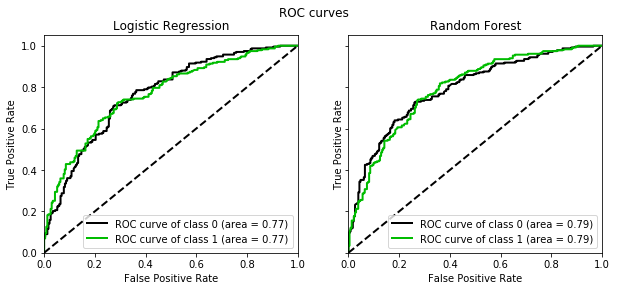

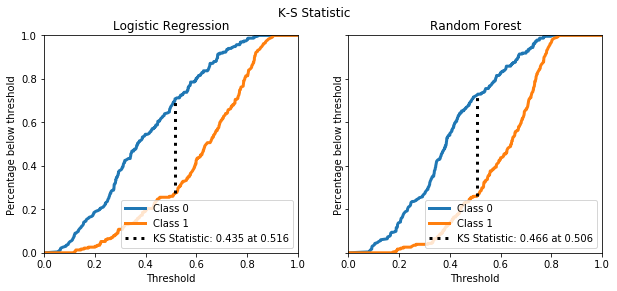

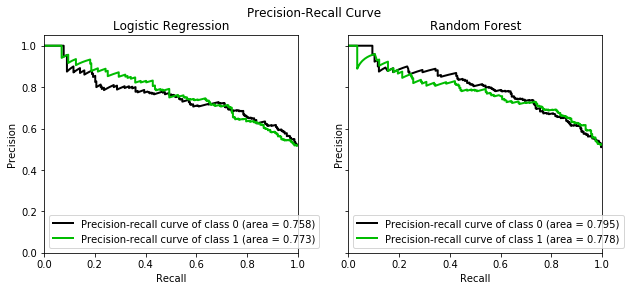

===== Cohort 1 : 10 - 29 months ======

Logistic Regression
	Train, test score  0.7387247278382582 0.7412587412587412
Confusion Matrix
     0    1
0  215   92
1   19  103
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       307
           1       0.53      0.84      0.65       122

    accuracy                           0.74       429
   macro avg       0.72      0.77      0.72       429
weighted avg       0.81      0.74      0.75       429

Random Forest
	Train, test score  0.7441679626749611 0.7226107226107226
Confusion Matrix
     0   1
0  219  88
1   31  91
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       307
           1       0.51      0.75      0.60       122

    accuracy                           0.72       429
   macro avg       0.69      0.73      0.70       429
weighted avg       0.77      0.72      0.73       429



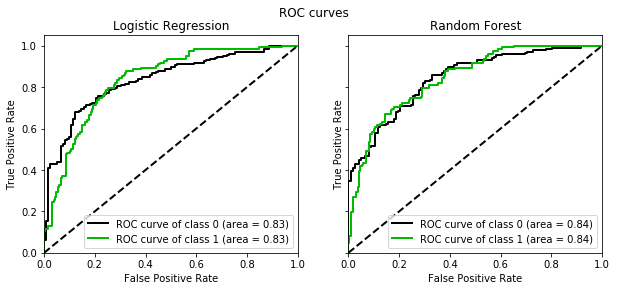

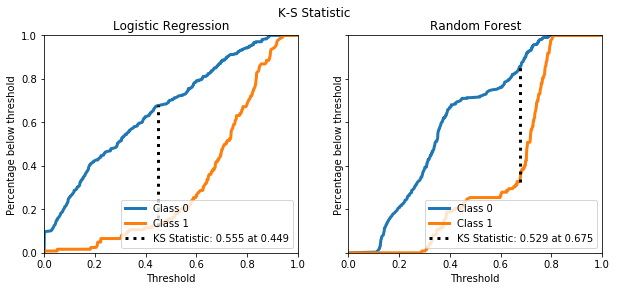

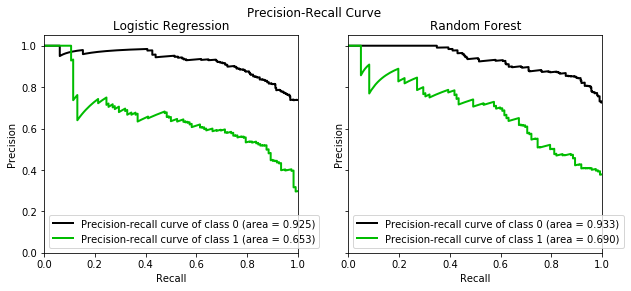

===== Cohort 2 : 30 - 55 months ======

Logistic Regression
	Train, test score  0.7121799844840963 0.6604651162790698
Confusion Matrix
     0    1
0  222  127
1   19   62
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       349
           1       0.33      0.77      0.46        81

    accuracy                           0.66       430
   macro avg       0.62      0.70      0.61       430
weighted avg       0.81      0.66      0.70       430

Random Forest
	Train, test score  0.7292474786656322 0.7209302325581395
Confusion Matrix
     0   1
0  250  99
1   21  60
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       349
           1       0.38      0.74      0.50        81

    accuracy                           0.72       430
   macro avg       0.65      0.73      0.65       430
weighted avg       0.82      0.72      0.75       430



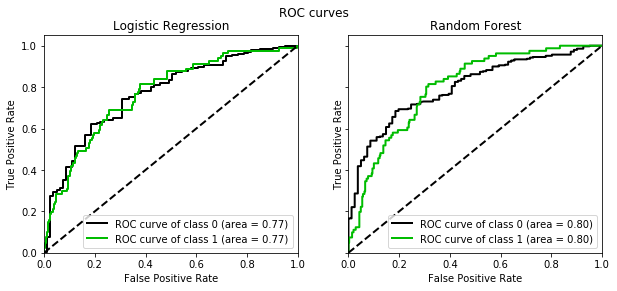

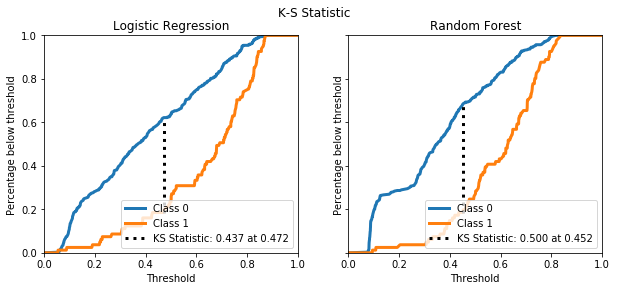

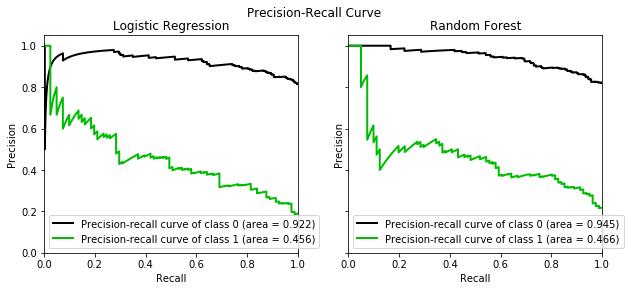

===== Cohort 3 : 56 - 72 months ======

Logistic Regression
	Train, test score  0.7583586626139818 0.7266514806378133
Confusion Matrix
     0    1
0  295  110
1   10   24
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       405
           1       0.18      0.71      0.29        34

    accuracy                           0.73       439
   macro avg       0.57      0.72      0.56       439
weighted avg       0.91      0.73      0.79       439

Random Forest
	Train, test score  0.7272036474164134 0.7061503416856492
Confusion Matrix
     0    1
0  282  123
1    6   28
              precision    recall  f1-score   support

           0       0.98      0.70      0.81       405
           1       0.19      0.82      0.30        34

    accuracy                           0.71       439
   macro avg       0.58      0.76      0.56       439
weighted avg       0.92      0.71      0.77       439



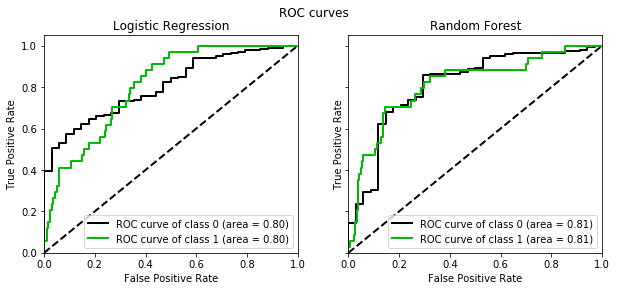

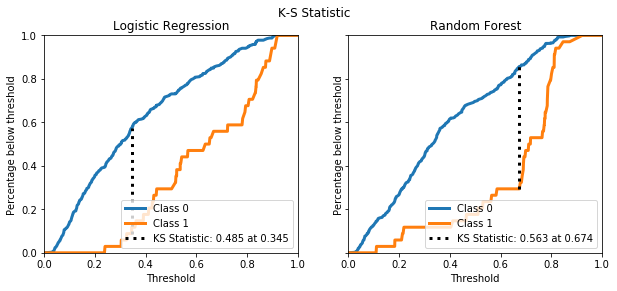

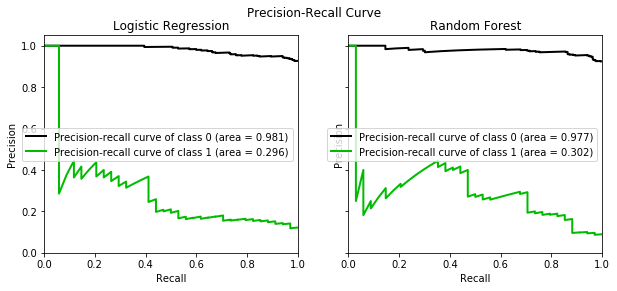

In [23]:
for i in range(n_cohorts):
    print_stuff(scores[i], treescores[i], f"===== Cohort {i} : {cohort_table.loc[i,'name']} ======\n" )
    plot_stuff(scores[i], treescores[i])

# Feature coefficients (Logistic Regression)
Because Random Forest is throwing away features randomly under the covers, the default output for
feature_importance from sklearn is not reliable. For a short-term project, let's just look at the 
feature coefficients for the LR model. 

In [17]:
for i in range(n_cohorts):
    print(f"===== Cohort {i} : {cohort_table.loc[i,'name']} ====== " )
    coeffs = pd.DataFrame(data=scores[i]['clf'].coef_, columns=scores[i]['cols'], index=['coef']).T
    coeffs['abs'] = coeffs.eval('abs(coef)')
    top5 = coeffs.sort_values('abs', ascending=False).head(5)[['coef']]
    print(top5)
    print("\n")

===== Cohort 0 : 0 - 9 months ====== 
                                 coef
Contract_Month-to-month      5.643592
Contract_One year            4.416457
InternetService_Fiber optic  2.121642
InternetService_DSL          0.956665
tenure                      -0.606777


===== Cohort 1 : 10 - 29 months ====== 
                                    coef
Contract_Month-to-month         0.832378
PhoneService_Yes               -0.677615
PaymentMethod_Electronic check  0.671727
InternetService_Fiber optic     0.527863
MonthlyCharges                  0.469122


===== Cohort 2 : 30 - 55 months ====== 
                             coef
Contract_Month-to-month  1.050554
PhoneService_Yes        -0.719882
TotalCharges             0.466194
Dependents_Yes          -0.351888
OnlineSecurity_Yes      -0.344729


===== Cohort 3 : 56 - 72 months ====== 
                             coef
TechSupport_Yes         -0.649062
StreamingMovies_Yes      0.643117
Contract_Month-to-month  0.494915
StreamingTV_Yes       

Cohort 0 is the only cohort where tenure comes in, with a negative coefficient. The the longer the amount of time the new
customer has stayed, the less likely they are to churn. This corresponds to the EDA observation that the 
highest churn is during the first month of service.

# Conclusions
Useful models were created for each cohort, with about 70 percent overall accuracy. 

One thing I missed during EDA was that having a phone line makes a customer less likely to churn compared to 
internet/TV only customers.

In [18]:
corr_example = pd.get_dummies(df.InternetService)
corr_example = pd.concat([df.MonthlyCharges, corr_example['Fiber optic']], axis=1)
corr_example.corr()

,MonthlyCharges,Fiber optic
MonthlyCharges,1.000000,0.787066
Fiber optic,0.787066,1.000000


One thing I noticed while tuning the models was that monthly charges are higher for fiber optic customers.
During EDA, I treated 'monthly payment' and 'fiber optic' as separate features when in fact they are correlated.
Overall is 79% correlated, but this is higher in the earlier cohorts than the later ones because the high paying 
fiber optic customers are dropping out more quickly over time. 

The business needs to investigate and try to separate how cost and product satisfaction issues affect the choice to drop the fiber optic service.

# Future work

A more logical cohort analysis would be splitting cohorts by contract type (since month-to-month customers can more easily churn) or product(s)
purchased (phone, internet, both) and then by years, so something like: 

   -  Month to month: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  One year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  Two year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   
Due to the relatively small dataset, it didn't make sense to slice-and-dice the data into that many pieces. Hence, my
choice to just make four cohorts by tenure quantiles.

The feature importance analysis is only run on the Logisitc Regression : Need to do a proper test (such as a permutation
test or a model-based feature search) to extract the feature importance from the Random Forest model. The two models could also be stacked
to see if combining their results would create a better model overall.

Any model could probably use a little more feature engineering and/or hyperparameter tuning and more data. Because the classes become more imbalanced as 
time goes on, more data would help the most with the last cohort. Given that the most churn is in the first cohort, this may be a lower priority. 